In [1]:
import torch
import torch.utils.cpp_extension
from pathlib import Path

In [2]:
matrix = torch.randn(4, 8, 32, 32768, device='cuda', dtype=torch.float32)
small = torch.tensor([[1, 2, 3]], device='cuda', dtype=torch.float32)

In [3]:
%%timeit
torch.nn.functional.softmax(matrix, dim=-1)
torch.cuda.synchronize()

128 μs ± 94.5 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [4]:
def naive_pytorch_softmax(x, dim=None):
    m = torch.max(x, dim=dim, keepdim=True)[0]
    e = torch.exp(x - m)
    s = torch.sum(e, dim=dim, keepdim=True)
    return e / s

In [5]:
torch.testing.assert_close(naive_pytorch_softmax(matrix, dim=-1), torch.nn.functional.softmax(matrix, dim=-1))

In [6]:
%%timeit
naive_pytorch_softmax(matrix, dim=-1)
torch.cuda.synchronize()

370 μs ± 82 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
def online_pytorch_softmax(x):
    x_flatten = x.reshape(-1, x.size(-1))
    rows, cols = x_flatten.shape
    m = torch.full((rows, 1), float('-inf'), device=x.device, dtype=x.dtype)
    s = torch.zeros((rows, 1), device=x.device, dtype=x.dtype)
    for c in range(cols):
        curr = x_flatten[:, c].unsqueeze(-1)
        prev_m = m
        m = torch.maximum(prev_m, curr)
        s = s * torch.exp(prev_m - m) + torch.exp(curr - m)
    y = torch.exp(x_flatten - m) / s
    return y.view_as(x)

In [8]:
torch.testing.assert_close(online_pytorch_softmax(matrix), torch.nn.functional.softmax(matrix, dim=-1))

In [9]:
%%timeit
online_pytorch_softmax(matrix)
torch.cuda.synchronize()

1.58 s ± 440 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
cuda_src1 = Path('softmax1.cu').read_text()
cpp_src1 = """
torch::Tensor softmax1(const torch::Tensor& x);
"""
my1 = torch.utils.cpp_extension.load_inline(
    "my1", cpp_src1, cuda_src1,
    functions=['softmax1'], extra_cuda_cflags=['--ptxas-options=-v'], verbose=True,
)

Using /home/belevich/.cache/torch_extensions/py312_cu126 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/belevich/.cache/torch_extensions/py312_cu126/my1/build.ninja...
/fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module my1...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module my1...


In [11]:
torch.testing.assert_close(my1.softmax1(matrix), torch.nn.functional.softmax(matrix, dim=-1))

In [12]:
%%timeit
my1.softmax1(matrix)
torch.cuda.synchronize()

83.6 ms ± 81.8 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
cuda_src2 = Path('softmax2.cu').read_text()
cpp_src2 = """
torch::Tensor softmax2(const torch::Tensor& x);
"""
my2 = torch.utils.cpp_extension.load_inline(
    "my2", cpp_src2, cuda_src2,
    functions=['softmax2'], extra_cuda_cflags=['--ptxas-options=-v'], verbose=True,
)

Using /home/belevich/.cache/torch_extensions/py312_cu126 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/belevich/.cache/torch_extensions/py312_cu126/my2/build.ninja...
/fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module my2...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module my2...


In [14]:
torch.testing.assert_close(my2.softmax2(matrix), torch.nn.functional.softmax(matrix, dim=-1))

In [15]:
%%timeit
my2.softmax2(matrix)
torch.cuda.synchronize()

137 μs ± 24.2 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [16]:
cuda_src3 = Path('softmax3.cu').read_text()
cpp_src3 = """
torch::Tensor softmax3(const torch::Tensor& x);
"""
my3 = torch.utils.cpp_extension.load_inline(
    "my3", cpp_src3, cuda_src3,
    functions=['softmax3'], extra_cuda_cflags=['--ptxas-options=-v'], verbose=True,
)

Using /home/belevich/.cache/torch_extensions/py312_cu126 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/belevich/.cache/torch_extensions/py312_cu126/my3/build.ninja...
/fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module my3...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module my3...


In [17]:
torch.testing.assert_close(my3.softmax3(matrix), torch.nn.functional.softmax(matrix, dim=-1))

In [18]:
%%timeit
my3.softmax3(matrix)
torch.cuda.synchronize()

138 μs ± 26.5 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [19]:
cuda_src2_shfl = Path('softmax2_shfl.cu').read_text()
cpp_src2_shfl = """
torch::Tensor softmax2_shfl(const torch::Tensor& x);
"""
my2_shfl = torch.utils.cpp_extension.load_inline(
    "my2_shfl", cpp_src2_shfl, cuda_src2_shfl,
    functions=['softmax2_shfl'], extra_cuda_cflags=['--ptxas-options=-v'], verbose=True,
)

Using /home/belevich/.cache/torch_extensions/py312_cu126 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/belevich/.cache/torch_extensions/py312_cu126/my2_shfl/build.ninja...
/fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module my2_shfl...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module my2_shfl...


In [20]:
torch.testing.assert_close(my2_shfl.softmax2_shfl(matrix), torch.nn.functional.softmax(matrix, dim=-1))

In [21]:
%%timeit
my2_shfl.softmax2_shfl(matrix)
torch.cuda.synchronize()

130 μs ± 26 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [22]:
cuda_src3_shfl = Path('softmax3_shfl.cu').read_text()
cpp_src3_shfl = """
torch::Tensor softmax3_shfl(const torch::Tensor& x);
"""
my3_shfl = torch.utils.cpp_extension.load_inline(
    "my3_shfl", cpp_src3_shfl, cuda_src3_shfl,
    functions=['softmax3_shfl'], extra_cuda_cflags=['--ptxas-options=-v'], verbose=True,
)

Using /home/belevich/.cache/torch_extensions/py312_cu126 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/belevich/.cache/torch_extensions/py312_cu126/my3_shfl/build.ninja...
/fsxl/belevich/miniconda3/lib/python3.12/site-packages/torch/utils/cpp_extension.py:2356: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module my3_shfl...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module my3_shfl...


In [23]:
torch.testing.assert_close(my3_shfl.softmax3_shfl(matrix), torch.nn.functional.softmax(matrix, dim=-1))

In [24]:
%%timeit
my3_shfl.softmax3_shfl(matrix)
torch.cuda.synchronize()

130 μs ± 9.62 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [25]:
import triton
import triton.language as tl

In [26]:
@triton.jit
def triton_softmax_kernel(
    x,
    x_row_stride,
    y,
    y_row_stride,
    n_cols,
    block_size: tl.constexpr,
):
    row_idx = tl.program_id(0)
    x_row_start = x + row_idx * x_row_stride
    col_offsets = tl.arange(0, block_size)
    row_ptrs = x_row_start + col_offsets
    mask = col_offsets < n_cols
    row = tl.load(row_ptrs, mask=mask, other=float('-inf'))

    row_max = tl.max(row, axis=0)
    safe_row = row - row_max
    exp_row = tl.exp(safe_row)
    sum_row = tl.sum(exp_row, axis=0)
    y_row_start = y + row_idx * y_row_stride
    y_ptrs = y_row_start + col_offsets
    tl.store(y_ptrs, exp_row / sum_row, mask=mask)

def triton_softmax(x: torch.Tensor) -> torch.Tensor:
    x_flatten = x.reshape(-1, x.size(-1))
    y = torch.empty_like(x_flatten)
    rows, cols = x_flatten.shape
    block_size = triton.next_power_of_2(cols)
    num_warps = 4
    if block_size > 2047:
        num_warps = 8
    elif block_size > 4095:
        num_warps = 16

    grid = (rows, )
    triton_softmax_kernel[grid](x_flatten, x_flatten.stride(0), y, y.stride(0), cols, block_size, num_warps=num_warps)
    
    return y.view_as(x)

In [27]:
torch.testing.assert_close(triton_softmax(matrix), torch.nn.functional.softmax(matrix, dim=-1))

In [28]:
%%timeit
triton_softmax(matrix)
torch.cuda.synchronize()

112 μs ± 185 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [29]:
@triton.jit
def triton_softmax2_kernel(
    x,
    x_row_stride,
    y,
    y_row_stride,
    n_cols,
    block_size: tl.constexpr,
):
    row_idx = tl.program_id(0)
    x_row_start = x + row_idx * x_row_stride
    y_row_start = y + row_idx * y_row_stride
    offsets = tl.arange(0, block_size)
    row_max = tl.full((), -float("inf"), dtype=tl.float32)
    for b in range(0, (n_cols + block_size - 1) // block_size):
        idx = b * block_size + offsets
        mask = idx < n_cols
        x_vals = tl.load(x_row_start + idx, mask=mask)
        row_max = tl.maximum(row_max, tl.max(x_vals.to(tl.float32)))

    row_sum = tl.zeros((), dtype=tl.float32)
    for b in range(0, (n_cols + block_size - 1) // block_size):
        idx = b * block_size + offsets
        mask = idx < n_cols
        x_vals = tl.load(x_row_start + idx, mask=mask, other=-float("inf"))
        x_vals = tl.exp(x_vals - row_max)
        row_sum += tl.sum(x_vals)
        tl.store(y_row_start + idx, x_vals, mask=mask)

    for b in range(0, (n_cols + block_size - 1) // block_size):
        idx = b * block_size + offsets
        mask = idx < n_cols
        y_vals = tl.load(y_row_start + idx, mask=mask)
        y_vals /= row_sum
        tl.store(y_row_start + idx, y_vals, mask=mask)
    

def triton_softmax2(x: torch.Tensor) -> torch.Tensor:
    x_flatten = x.reshape(-1, x.size(-1))
    y = torch.empty_like(x_flatten)
    rows, cols = x_flatten.shape
    block_size = 1024 * 32
    num_warps = 4
    if block_size > 2047:
        num_warps = 8
    elif block_size > 4095:
        num_warps = 16
    grid = (rows,)
    triton_softmax2_kernel[grid](x_flatten, x_flatten.stride(0), y, y.stride(0), cols, block_size, num_warps=num_warps)
    return y.view_as(x)

In [30]:
torch.testing.assert_close(triton_softmax2(matrix), torch.nn.functional.softmax(matrix, dim=-1))

In [31]:
%%timeit
triton_softmax2(matrix)
torch.cuda.synchronize()

173 μs ± 91.4 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [32]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],  # Argument names to use as an x-axis for the plot.
        x_vals=[2**i for i in range(12, 20, 1)],  # Different possible values for `x_name`.
        x_log=True,  # x axis is logarithmic.
        line_arg='provider',  # Argument name whose value corresponds to a different line in the plot.
        line_vals=['triton', 'torch', 'softmax2', 'softmax2_shfl', 'softmax3', 'softmax3_shfl', 'triton2'],  # Possible values for `line_arg`.
        line_names=['Triton', 'Torch', 'SM2', 'SM2SHFL', 'SM3', 'SM3SHFL', 'Triton2'],  # Label name for the lines.
        styles=[('blue', '-'), ('green', '-'), ('red', '-'), ('pink', '-'), ('yellow', '-'), ('black', '-'), ('orange', '-')],  # Line styles.
        ylabel='GB/s',  # Label name for the y-axis.
        plot_name='softmax-performance',  # Name for the plot. Used also as a file name for saving the plot.
        args={},  # Values for function arguments not in `x_names` and `y_name`.
    ))
def triton_softmax_benchmark(size, provider):
    x = torch.rand((1, size), device="cuda", dtype=torch.float32)
    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.nn.functional.softmax(x), quantiles=quantiles)
    if provider == "softmax2":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: my2.softmax2(x), quantiles=quantiles)
    if provider == "softmax2_shfl":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: my2_shfl.softmax2_shfl(x), quantiles=quantiles)
    if provider == "softmax3":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: my3.softmax3(x), quantiles=quantiles)
    if provider == "softmax3_shfl":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: my3_shfl.softmax3_shfl(x), quantiles=quantiles)
    if provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_softmax(x), quantiles=quantiles)
    if provider == 'triton2':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: triton_softmax2(x), quantiles=quantiles)
    gbps = lambda ms: 2 * x.numel() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

/tmp/ipykernel_3957483/2724057920.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.nn.functional.softmax(x), quantiles=quantiles)
/tmp/ipykernel_3957483/2724057920.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.nn.functional.softmax(x), quantiles=quantiles)
/tmp/ipykernel_3957483/2724057920.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.nn.functional.softmax(x), quantiles=quantiles)
/tmp/ipykernel_3957483/2724057920.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ms, min_ms, max_ms = trito

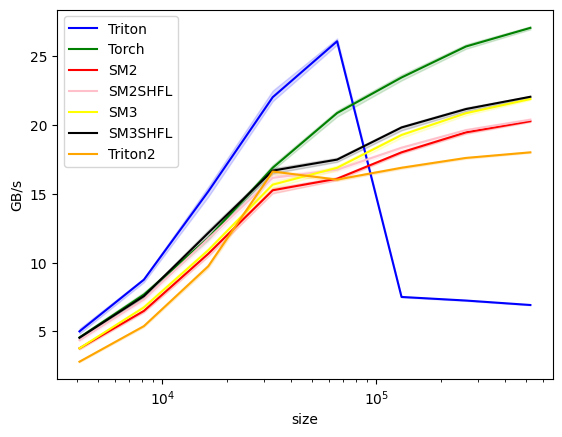

softmax-performance:
       size     Triton      Torch        SM2    SM2SHFL        SM3    SM3SHFL    Triton2
0    4096.0   4.995122   4.551111   3.764706   4.357447   3.764706   4.530973   2.790191
1    8192.0   8.752137   7.670412   6.481013   7.314286   6.736842   7.557196   5.375328
2   16384.0  15.170371  11.770115  10.638961  11.736389  10.893617  12.154302   9.729216
3   32768.0  22.021505  16.890722  15.255121  16.157790  15.663479  16.684317  16.616632
4   65536.0  26.089172  20.871338  16.094303  16.752556  16.890722  17.485593  16.031311
5  131072.0   7.498398  23.455976  18.014294  18.347145  19.275294  19.823351  16.890722
6  262144.0   7.237548  25.710474  19.464211  19.627433  20.858053  21.161123  17.607738
7  524288.0   6.913080  27.064217  20.277228  20.384448  21.889112  22.054855  18.014294


In [33]:
triton_softmax_benchmark.run(print_data=True, show_plots=True)

In [34]:
torch.cuda.get_device_properties()

_CudaDeviceProperties(name='NVIDIA H200', major=9, minor=0, total_memory=143167MB, multi_processor_count=132, uuid=ebf08fa4-8f80-7906-d64b-99af1a15f76e, L2_cache_size=60MB)

In [35]:
device_properties = torch.cuda.get_device_properties(0) 
device_properties.shared_memory_per_multiprocessor

233472